Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

Step 1: Loading the dataset

In [26]:
df = pd.read_csv("C:\\Users\\LENOVO\\Downloads\\archive (10)\\kc_house_data.csv")  
print("Shape:", df.shape)
df.head()

Shape: (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Step 2: Quick inspection

In [27]:
print(df.info())
print(df.describe(include="all").T)
print("Missing values per column:", df.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Step 3: Exploratory visuals

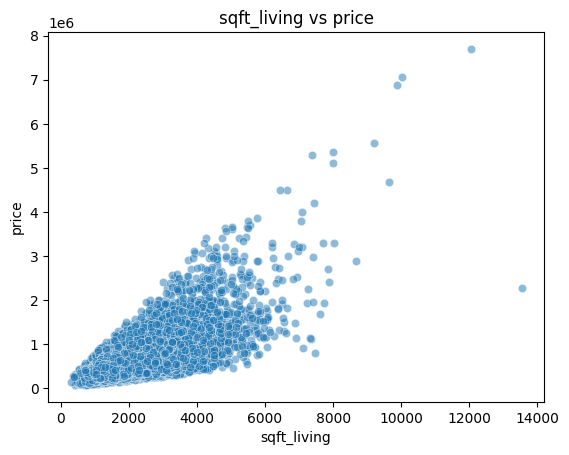

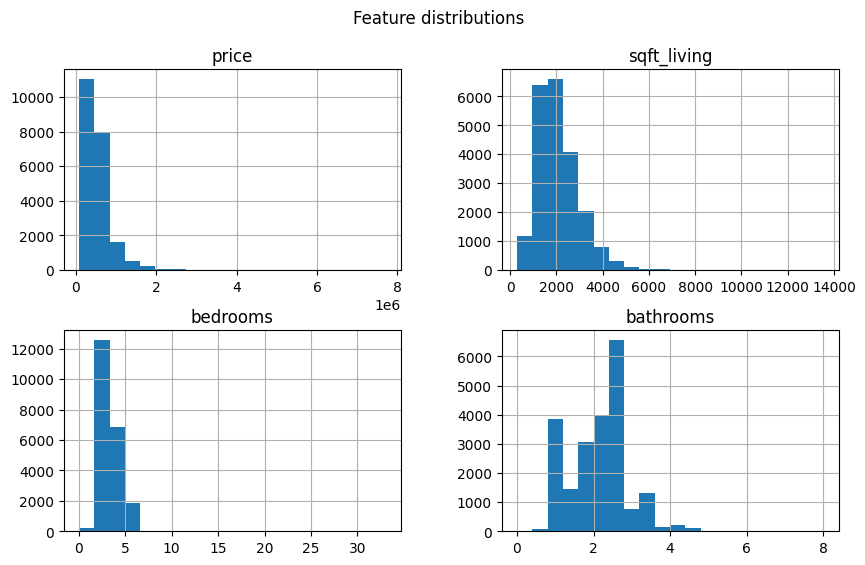

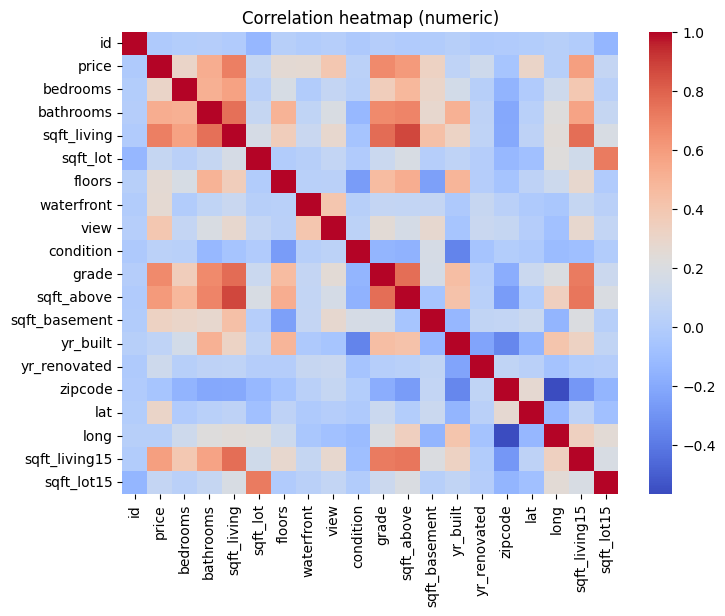

In [28]:
# Price vs size
sns.scatterplot(data=df, x="sqft_living", y="price", alpha=0.5)
plt.title("sqft_living vs price")
plt.show()
# Distributions of features
num_cols_quick = ["price","sqft_living","bedrooms","bathrooms"]
df[num_cols_quick].hist(bins=20, figsize=(10,6))
plt.suptitle("Feature distributions")
plt.show()
# Correlation heatmap for numerical data
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation heatmap (numeric)")
plt.show()

Step 4: Selecting features & Bsic cleaning

In [29]:
#Choosing features 
features = ["sqft_living", "bedrooms", "bathrooms", "floors", "zipcode"]
target = "price"
df_model = df[features + [target]].copy()
#Missing value handling
for col in ["sqft_living", "bedrooms", "bathrooms", "floors"]:
    df_model[col] = df_model[col].fillna(df_model[col].median())
df_model["zipcode"] = df_model["zipcode"].astype(str).fillna("unknown")  # categorical as string
X = df_model[features]
y = df_model[target]

Step 5:Train Test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((17290, 5), (4323, 5))

Step 6: Preprocessing pipeline

In [31]:
numeric_features = ["sqft_living", "bedrooms", "bathrooms", "floors"]
categorical_features = ["zipcode"]
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),])


Step 7: Train Model 1: Linear Regression

In [32]:
linreg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())])
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"Linear Regression MAE: {mae_lin:,.0f} and RMSE: {rmse_lin:,.0f}")

Linear Regression MAE: 113,722 and RMSE: 40,533,040,847


Step 8: Train Model 2: Gradient Boosting

In [35]:
gbr = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))])
gbr.fit(X_train, y_train)
y_pred_gb = gbr.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Gradient Boosting → MAE: {mae_gb:,.0f} and RMSE: {rmse_gb:,.0f}")

Gradient Boosting → MAE: 123,250 and RMSE: 46,601,912,940


Step 9: Pick the better model and visualize Predicted vs Actual

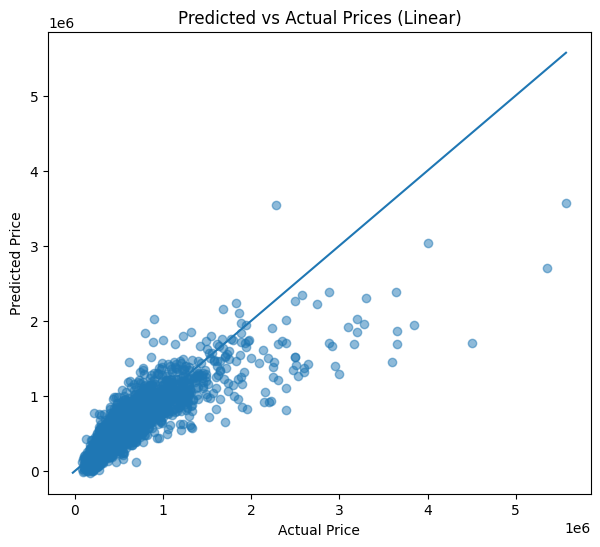

In [36]:
# Choose best wit RMSE
best_name, best_pred = ("GBR", y_pred_gb) if rmse_gb < rmse_lin else ("Linear", y_pred_lin)
plt.figure(figsize=(7,6))
plt.scatter(y_test, best_pred, alpha=0.5)
lims = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(lims, lims)  # y=x line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title(f"Predicted vs Actual Prices ({best_name})")
plt.show()

Step 10: Residual analysis

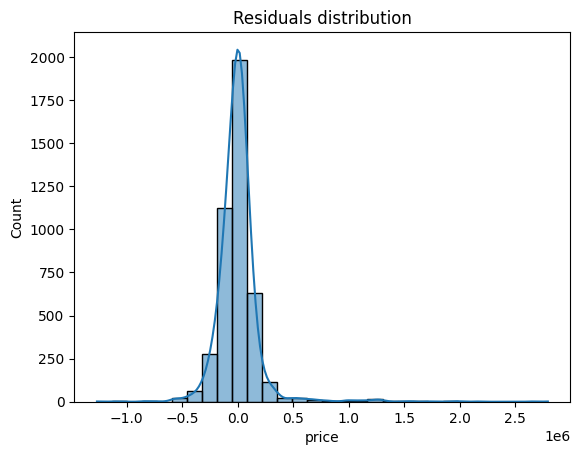

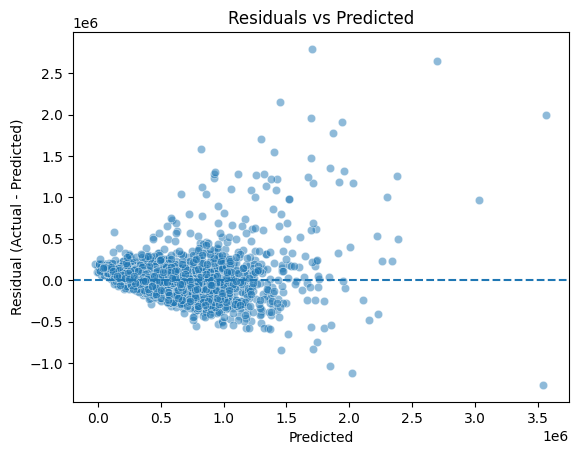

In [37]:
residuals = y_test - best_pred
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals distribution")
plt.show()
sns.scatterplot(x=best_pred, y=residuals, alpha=0.5)
plt.axhline(0, ls="--")
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.show()